In [1]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import requests
import os
import tiktoken
import torch
from torch import nn as nn
import math
import time

# 1. Dataset

## Escolhendo os 2 livros

In [2]:
urls = [
    "https://www.gutenberg.org/cache/epub/26777/pg26777.txt",

    "https://www.gutenberg.org/cache/epub/22730/pg22730.txt"
]

for i,url in enumerate(urls):
  if not os.path.exists(f"text{i}.txt"):
    file_path = f"text{i}.txt"
    response = requests.get(url, timeout=30)
    response.raise_for_status()

    with open(file_path, "wb") as f:
        f.write(response.content)


In [3]:

with open("text0.txt", "r", encoding="utf-8") as f:
    raw_text_1 = f.read()

with open("text1.txt", "r", encoding="utf-8") as f:
    raw_text_2 = f.read()

print("Total number of character:", len(raw_text_1))
print(raw_text_1[:99])

print("Total number of character:", len(raw_text_2))
print(raw_text_2[:99])

Total number of character: 371685
﻿The Project Gutenberg eBook of A Revolução Portugueza: O 5 de Outubro (Lisboa 1910)
    
This eboo
Total number of character: 21941
﻿The Project Gutenberg eBook of O Jardim da Pierrette
    
This ebook is for the use of anyone anyw


## Fazendo a limpeza

In [4]:
marcador_inicio = "*** START OF THE PROJECT GUTENBERG EBOOK"
marcador_fim = "*** END OF THE PROJECT GUTENBERG EBOOK"
posicao_inicio = raw_text_1.find(marcador_inicio)
posicao_fim = raw_text_1.find(marcador_fim)

texto_limpo = raw_text_1[posicao_inicio + len(marcador_inicio) : posicao_fim]
texto_limpo = texto_limpo.strip()

print("Começo do livro:\n", texto_limpo[:200])
print("\nFim do livro:\n", texto_limpo[-200:])

Começo do livro:
 A REVOLUÇÃO PORTUGUEZA: O 5 DE OUTUBRO (LISBOA 1910) ***




Produced by Pedro Saborano and the Online Distributed
Proofreading Team at https://www.pgdp.net






Bibliotheca Historica
(Popular e Illu

Fim do livro:
 Os mais baratos e elegantes brindes para creanças e premios escolares

200 réis cada volume brochado--300 réis enc. em percalina

Pedidos a
ALFREDO DAVID - Encadernador
Rua Serpa Pinto, 30 a 36 Lisboa


In [5]:
posicao_inicio = raw_text_2.find(marcador_inicio)
posicao_fim = raw_text_2.find(marcador_fim)

texto_limpo_2 = raw_text_2[posicao_inicio + len(marcador_inicio) : posicao_fim]
texto_limpo_2 = texto_limpo_2.strip()

print("Começo do livro:\n", texto_limpo_2[:200])
print("\nFim do livro:\n", texto_limpo_2[-200:])

Começo do livro:
 O JARDIM DA PIERRETTE ***




Produced by Vasco Salgado




+O

JARDIM

DA

PIERRETTE+


EDIÇÃO DE ALMADA-NEGREIROS


REPRESENTADO PELA
PRIMEIRA VEZ NO
ATRO DA TRINDADE

JUNHO DE 1918




[Nota do Tra

Fim do livro:
 eyner (Mafra).




[Nota do Transcritor: Aqui surge um desenho de Arlequim.]

Dona Maria José Soares Cardoso (Marco).





End of Project Gutenberg's O Jardim da Pierrette, by José de Almada Negreiros


In [6]:
preprocessed_corpus = texto_limpo + "\n\n" + texto_limpo_2

len(preprocessed_corpus)

354900

## Divisão de Treino e Teste

In [7]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 256,
    "emb_dim": 256,
    "n_heads": 4,
    "n_layers": 4,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [8]:

class GPTDatasetV1(Dataset):
    def __init__(self, txt, tokenizer, max_length, stride):
        self.input_ids = []
        self.target_ids = []

        token_ids = tokenizer.encode(txt, allowed_special={"<|endoftext|>"})
        assert len(token_ids) > max_length, "Number of tokenized inputs must at least be equal to max_length+1"

        for i in range(0, len(token_ids) - max_length, stride):
            input_chunk = token_ids[i:i + max_length]
            target_chunk = token_ids[i + 1: i + max_length + 1]
            self.input_ids.append(torch.tensor(input_chunk))
            self.target_ids.append(torch.tensor(target_chunk))

    def __len__(self):
        return len(self.input_ids)

    def __getitem__(self, idx):
        return self.input_ids[idx], self.target_ids[idx]

In [9]:
def create_dataloader_v1(txt, batch_size=4, max_length=256,
                         stride=128, shuffle=True, drop_last=True,
                         num_workers=0):

    tokenizer = tiktoken.get_encoding("gpt2")
    dataset = GPTDatasetV1(txt, tokenizer, max_length, stride)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=drop_last,
        num_workers=num_workers
    )

    return dataloader

In [10]:
train_ratio = 0.80
split_idx = int(train_ratio * len(preprocessed_corpus))
train_data = preprocessed_corpus[:split_idx]
val_data = preprocessed_corpus[split_idx:]

In [11]:
torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [12]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("Training tokens:", train_tokens)
print("Validation tokens:", val_tokens)
print("All tokens:", train_tokens + val_tokens)

Training tokens: 104448
Validation tokens: 26368
All tokens: 130816


# 2. Treinar Modelos

### Classes para arquitetura do GPT

In [13]:
class CausalAttention(nn.Module):

    def __init__(self, d_in, d_out, context_length,
                 dropout, qkv_bias=False):
        super().__init__()
        self.d_out = d_out
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key   = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1)) # New

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)

        attn_scores = queries @ keys.transpose(1, 2)
        attn_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf)
        attn_weights = torch.softmax(
            attn_scores / keys.shape[-1]**0.5, dim=-1
        )
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        return context_vec


class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads
        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.W_key(x)
        queries = self.W_query(x)
        values = self.W_value(x)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim)
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)
        attn_scores = queries @ keys.transpose(2, 3)
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)
        context_vec = (attn_weights @ values).transpose(1, 2)
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec)

        return context_vec

class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))

    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        norm_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * norm_x + self.shift

class GELU(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) *
            (x + 0.044715 * torch.pow(x, 3))
        ))

class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"]),
        )

    def forward(self, x):
        return self.layers(x)

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            num_heads=cfg["n_heads"],
            dropout=cfg["drop_rate"],
            qkv_bias=cfg["qkv_bias"])
        self.ff = FeedForward(cfg)
        self.norm1 = LayerNorm(cfg["emb_dim"])
        self.norm2 = LayerNorm(cfg["emb_dim"])
        self.drop_shortcut = nn.Dropout(cfg["drop_rate"])

    def forward(self, x):
        shortcut = x
        x = self.norm1(x)
        x = self.att(x)
        x = self.drop_shortcut(x)
        x = x + shortcut
        shortcut = x
        x = self.norm2(x)
        x = self.ff(x)
        x = self.drop_shortcut(x)
        x = x + shortcut

        return x
class SinusoidalPositionalEmbedding(nn.Module):
    def __init__(self, context_length, d_model):
        super().__init__()
        pe = torch.zeros(context_length, d_model)
        position = torch.arange(0, context_length, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        self.register_buffer('pe', pe)

    def forward(self, x):
        return self.pe[x, :]

class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.emb_type = cfg.get("emb_type", "original")

        if self.emb_type == "original":
            self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        elif self.emb_type == "sinusoid":
            self.pos_emb = SinusoidalPositionalEmbedding(cfg["context_length"], cfg["emb_dim"])

        elif self.emb_type == "none":
            self.pos_emb = None
        else:
            raise ValueError(f"Tipo de embedding desconhecido: {self.emb_type}")

        self.trf_blocks = nn.Sequential(
            *[TransformerBlock(cfg) for _ in range(cfg["n_layers"])])

        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"], cfg["vocab_size"], bias=False
        )

    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)

        if self.pos_emb is not None:
            positions = torch.arange(seq_len, device=in_idx.device)
            pos_embeds = self.pos_emb(positions)
            x = tok_embeds + pos_embeds
        else:
            x = tok_embeds
        x = self.drop_emb(x)
        x = self.trf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        return logits

### Instanciando os modelos

In [14]:
GPT_CONFIG_ORIGINAL = GPT_CONFIG_124M.copy()
GPT_CONFIG_ORIGINAL["emb_type"] = "original"
model_original = GPTModel(GPT_CONFIG_ORIGINAL)

GPT_CONFIG_SENOIDAL = GPT_CONFIG_124M.copy()
GPT_CONFIG_SENOIDAL["emb_type"] = "sinusoid"
model_senoidal = GPTModel(GPT_CONFIG_SENOIDAL)

GPT_CONFIG_NONE = GPT_CONFIG_124M.copy()
GPT_CONFIG_NONE["emb_type"] = "none"
model_sem_posicao = GPTModel(GPT_CONFIG_NONE)

print("Modelos criados com sucesso!")
print(f"Modelo Original Pos Emb: {model_original.pos_emb}")
print(f"Modelo Senoidal Pos Emb: {model_senoidal.pos_emb}")
print(f"Modelo Sem Posição Pos Emb: {model_sem_posicao.pos_emb}")

Modelos criados com sucesso!
Modelo Original Pos Emb: Embedding(256, 256)
Modelo Senoidal Pos Emb: SinusoidalPositionalEmbedding()
Modelo Sem Posição Pos Emb: None


### Cáculo da função de perda

In [15]:
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)

    loss = torch.nn.functional.cross_entropy(
        logits.flatten(0, 1),
        target_batch.flatten()
    )
    return loss

def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")

    num_batches = num_batches if num_batches is not None else len(data_loader)
    model.eval()
    with torch.no_grad():
        for i, (input_batch, target_batch) in enumerate(data_loader):
            if i < num_batches:
                loss = calc_loss_batch(input_batch, target_batch, model, device)
                total_loss += loss.item()
            else:
                break
    return total_loss / num_batches

In [16]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter):

    model.to(device)

    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen = 0
    start_time = time.time()

    for epoch in range(num_epochs):
        model.train()

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad()
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward()
            optimizer.step()

            tokens_seen += input_batch.numel()
        if epoch % eval_freq == 0 or epoch == num_epochs - 1:
            train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
            val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)

            train_perplexity = torch.exp(torch.tensor(train_loss))
            val_perplexity = torch.exp(torch.tensor(val_loss))

            print(f"Época {epoch+1:03d} | "
                  f"Train Loss: {train_loss:.4f} (Ppl: {train_perplexity:.2f}) | "
                  f"Val Loss: {val_loss:.4f} (Ppl: {val_perplexity:.2f})")

            train_losses.append(train_loss)
            val_losses.append(val_loss)
            track_tokens_seen.append(tokens_seen)

    return train_losses, val_losses, track_tokens_seen

In [17]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Usando dispositivo: {device}")

Usando dispositivo: cuda


In [18]:
learning_rate = 5e-4
num_epochs = 5
eval_freq = 1
eval_iter = 5

resultados = {}

modelos = [
    ("GPT-2 Original", model_original),
    ("GPT-2 Senoidal", model_senoidal),
    ("GPT-2 Sem Posição", model_sem_posicao)
]

In [19]:
for nome, modelo in modelos:
    print(f"\nTraining {nome} ...")

    optimizer = torch.optim.AdamW(modelo.parameters(), lr=learning_rate, weight_decay=0.1)

    train_l, val_l, tokens = train_model_simple(
        modelo, train_loader, val_loader, optimizer, device,
        num_epochs=num_epochs, eval_freq=eval_freq, eval_iter=eval_iter
    )

    resultados[nome] = {
        "train_loss": train_l,
        "val_loss": val_l,
        "final_val_ppl": torch.exp(torch.tensor(val_l[-1])).item()
    }


Training GPT-2 Original ...
Época 001 | Train Loss: 5.3550 (Ppl: 211.67) | Val Loss: 5.6456 (Ppl: 283.05)
Época 002 | Train Loss: 4.3404 (Ppl: 76.74) | Val Loss: 4.8911 (Ppl: 133.11)
Época 003 | Train Loss: 3.9156 (Ppl: 50.18) | Val Loss: 4.6371 (Ppl: 103.25)
Época 004 | Train Loss: 3.5826 (Ppl: 35.97) | Val Loss: 4.5048 (Ppl: 90.45)
Época 005 | Train Loss: 3.2477 (Ppl: 25.73) | Val Loss: 4.4665 (Ppl: 87.05)

Training GPT-2 Senoidal ...
Época 001 | Train Loss: 4.9915 (Ppl: 147.15) | Val Loss: 5.2383 (Ppl: 188.36)
Época 002 | Train Loss: 4.1167 (Ppl: 61.36) | Val Loss: 4.6527 (Ppl: 104.87)
Época 003 | Train Loss: 3.9043 (Ppl: 49.62) | Val Loss: 4.4241 (Ppl: 83.44)
Época 004 | Train Loss: 3.4163 (Ppl: 30.46) | Val Loss: 4.2938 (Ppl: 73.25)
Época 005 | Train Loss: 3.3104 (Ppl: 27.40) | Val Loss: 4.2226 (Ppl: 68.21)

Training GPT-2 Sem Posição ...
Época 001 | Train Loss: 4.8224 (Ppl: 124.26) | Val Loss: 5.0364 (Ppl: 153.92)
Época 002 | Train Loss: 4.0282 (Ppl: 56.16) | Val Loss: 4.5454 (P

In [34]:
resultados.items()

dict_items([('GPT-2 Original', {'train_loss': [5.355027484893799, 4.34038724899292, 3.915582513809204, 3.582610273361206, 3.2477184772491454], 'val_loss': [5.645628166198731, 4.891138553619385, 4.6371441841125485, 4.504815769195557, 4.466499519348145], 'final_val_ppl': 87.05145263671875}), ('GPT-2 Senoidal', {'train_loss': [4.991470050811768, 4.116700315475464, 3.9043339252471925, 3.4162786960601808, 3.3103620052337646], 'val_loss': [5.238344192504883, 4.652700042724609, 4.424072360992431, 4.293831205368042, 4.2225565910339355], 'final_val_ppl': 68.2076416015625}), ('GPT-2 Sem Posição', {'train_loss': [4.822354984283447, 4.028163909912109, 3.74432373046875, 3.6052702903747558, 3.323336887359619], 'val_loss': [5.036438465118408, 4.5454127311706545, 4.347992372512818, 4.228158283233642, 4.2314033031463625], 'final_val_ppl': 68.81373596191406})])

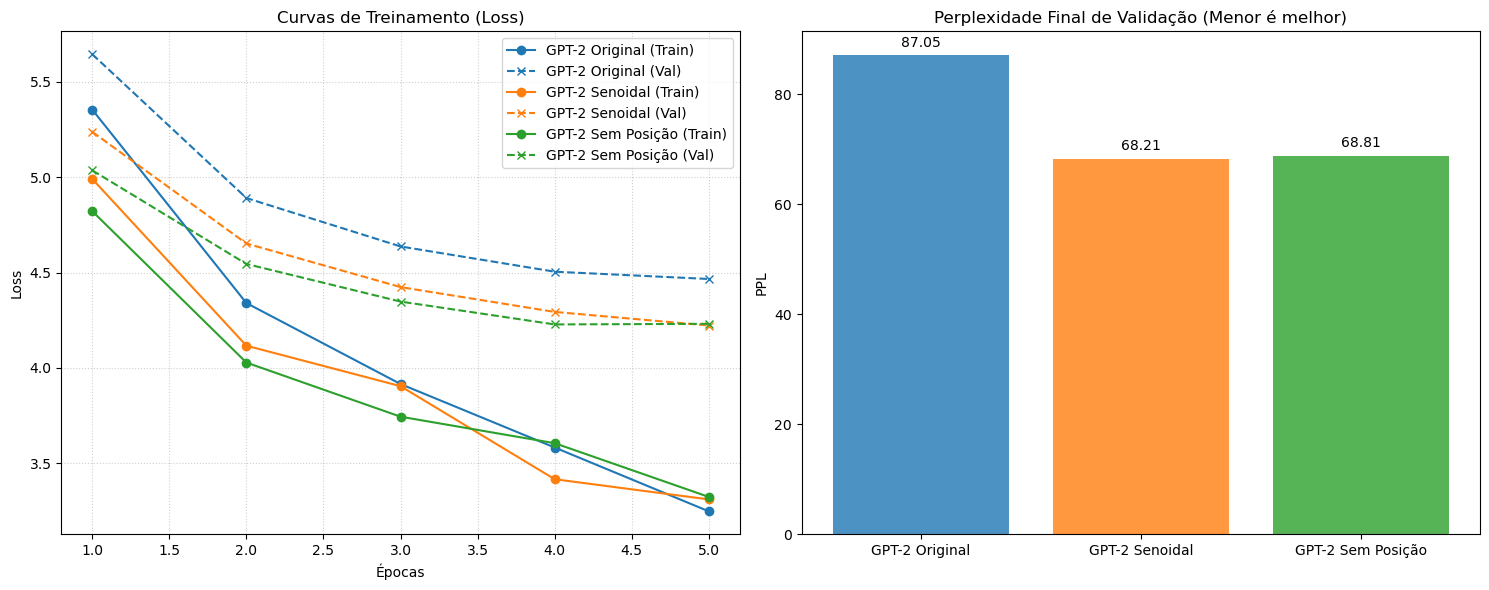

In [44]:
# Configuração da figura com 2 subplots (1 linha, 2 colunas)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

epochs = range(1, 6) # 5 épocas
colors = ['#1f77b4', '#ff7f0e', '#2ca02c'] # Cores para cada modelo

# 1. Plot de Loss (Treino e Validação)
for i, (name, metrics) in enumerate(resultados.items()):
    # Linha contínua para Treino, tracejada para Validação
    ax1.plot(epochs, metrics['train_loss'], label=f'{name} (Train)', color=colors[i], marker='o')
    ax1.plot(epochs, metrics['val_loss'], label=f'{name} (Val)', color=colors[i], linestyle='--', marker='x')

ax1.set_title('Curvas de Treinamento (Loss)')
ax1.set_xlabel('Épocas')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True, linestyle=':', alpha=0.6)

# 2. Plot de Perplexidade Final (Barra)
model_names = list(resultados.keys())
ppl_values = [metrics['final_val_ppl'] for metrics in resultados.values()]

bars = ax2.bar(model_names, ppl_values, color=colors, alpha=0.8)
ax2.set_title('Perplexidade Final de Validação (Menor é melhor)')
ax2.set_ylabel('PPL')

# Adicionar os valores exatos em cima das barras
for bar in bars:
    yval = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2, yval + 1, round(yval, 2), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [21]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    # idx is (batch, n_tokens) array of indices in the current context
    for _ in range(max_new_tokens):
        
        # Crop current context if it exceeds the supported context size
        # E.g., if LLM supports only 5 tokens, and the context size is 10
        # then only the last 5 tokens are used as context
        idx_cond = idx[:, -context_size:]
        
        # Get the predictions
        with torch.no_grad():
            logits = model(idx_cond)
        
        # Focus only on the last time step
        # (batch, n_tokens, vocab_size) becomes (batch, vocab_size)
        logits = logits[:, -1, :]  

        # Apply softmax to get probabilities
        probas = torch.softmax(logits, dim=-1)  # (batch, vocab_size)

        # Get the idx of the vocab entry with the highest probability value
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)  # (batch, 1)

        # Append sampled index to the running sequence
        idx = torch.cat((idx, idx_next), dim=1)  # (batch, n_tokens+1)

    return idx

In [22]:
tokenizer = tiktoken.get_encoding("gpt2")
start_prompt = ["O amor e a","O Brasil é", "Minha terra"]
max_new_tokens = 30
context_size = 256 


for context in start_prompt:
    token_ids = tokenizer.encode(context)
    token_ids = torch.tensor(token_ids).unsqueeze(0).to(device)

    print(f"Frase inicial: '{context}'\n")

    meus_modelos = [
        ("Original", model_original),
        ("Senoidal", model_senoidal),
        ("Sem Posição", model_sem_posicao)
    ]


    for nome, modelo in meus_modelos:
        modelo.eval()
        
        out_ids = generate_text_simple(
            model=modelo,
            idx=token_ids,
            max_new_tokens=max_new_tokens,
            context_size=context_size
        )
        
        decoded_text = tokenizer.decode(out_ids.squeeze(0).tolist())
        
        print(f"--- {nome} ---")
        print(decoded_text)
        print("-" * 50)

Frase inicial: 'O amor e a'

--- Original ---
O amor e a

militares. O movimento de Lisboa e oução Chagas forção de



s
--------------------------------------------------
--- Senoidal ---
O amor e a
de instruagem de que o movimento de que ou-se ao de
de o movimento de que o
--------------------------------------------------
--- Sem Posição ---
O amor e a


Ao, por um d'um _comité_, por um d'um _comité_, por um _com
--------------------------------------------------
Frase inicial: 'O Brasil é'

--- Original ---
O Brasil é que ou

sahiras forção do movimento de Lisboa e das forção de que ouç
--------------------------------------------------
--- Senoidal ---
O Brasil é
de instruagem de que o movimento de que ou-se ao de
de o movimento de que o
--------------------------------------------------
--- Sem Posição ---
O Brasil é



Ao, por um d'um _complot_, por um grupos de Sá Cardoso, por um gru
--------------------------------------------------
Frase inicial: 'Minha terra'

--- Original -